In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sys
from pylab import rcParams
from geopy.geocoders import Nominatim
from sklearn.preprocessing import LabelEncoder



# read the CSV file into a DataFrame object
energyData = pd.read_csv(r'C:\Users\torst\anaconda3\O4\Datat\Energy and weather datasets\energy_dataset.csv')
weatherData = pd.read_csv(r'C:\Users\torst\anaconda3\O4\Datat\Energy and weather datasets\weather_features.csv')

energyData.set_index('time', inplace = True)
weatherData.set_index('dt_iso', inplace = True)

energyData.columns = energyData.columns.map(lambda x : x+'_MWh' if x !='price day ahead' and x!='price actual' else x)
columns = energyData.columns[energyData.columns.str.contains('price day ahead|price actual')]
energyData.rename(columns = dict(zip(columns, columns + '_€/Mwh')), inplace=True)

energyData = energyData.drop(['generation hydro pumped storage aggregated_MWh', 
                              'forecast wind offshore eday ahead_MWh'], axis=1)

energyData.interpolate(method='linear', inplace=True, axis=0)

energyData = energyData.drop(['generation fossil coal-derived gas_MWh', 
                              'generation fossil oil shale_MWh', 'generation fossil peat_MWh', 
                              'generation geothermal_MWh', 'generation marine_MWh', 
                              'generation wind offshore_MWh'], axis=1)

weatherData = weatherData.reset_index().drop_duplicates(subset=['dt_iso', 'city_name']).set_index('dt_iso')
weatherData = weatherData.reset_index()
weatherData = weatherData.rename(columns = {'dt_iso':'time'})

cities = weatherData['city_name'].unique().tolist()
geolocator = Nominatim(user_agent="Energy_Data_Location_ANN")

def geo_locator(city, country):
    loc = geolocator.geocode(str(city + ',' + country))
    return (loc.latitude, loc.longitude)

# 
latitudes = []
longitudes = []

for i in cities:
    location = geo_locator(i,'Spain')
    latitudes.append(location[0])
    longitudes.append(location[1])
    
    
weatherData['Latitude'] = 0
weatherData['Longitude'] = 0


weatherData['Latitude'].loc[weatherData['city_name']=='Valencia'] = latitudes[0]
weatherData['Latitude'].loc[weatherData['city_name']=='Madrid'] = latitudes[1]
weatherData['Latitude'].loc[weatherData['city_name']=='Bilbao'] = latitudes[2]
weatherData['Latitude'].loc[weatherData['city_name']==' Barcelona'] = latitudes[3]
weatherData['Latitude'].loc[weatherData['city_name']=='Seville'] = latitudes[4]

weatherData['Longitude'].loc[weatherData['city_name']=='Valencia'] = longitudes[0]
weatherData['Longitude'].loc[weatherData['city_name']=='Madrid'] = longitudes[1]
weatherData['Longitude'].loc[weatherData['city_name']=='Bilbao'] = longitudes[2]
weatherData['Longitude'].loc[weatherData['city_name']==' Barcelona'] = longitudes[3]
weatherData['Longitude'].loc[weatherData['city_name']=='Seville'] = longitudes[4]

weatherMain_values = weatherData['weather_main'].unique().tolist()
weatherDescription_values = weatherData['weather_description'].unique().tolist()
weatherIcon_values = weatherData['weather_icon'].unique().tolist()

label_encoder = LabelEncoder()

weatherData['weather_main'] = label_encoder.fit_transform(weatherData['weather_main'])
weatherData['weather_description'] = label_encoder.fit_transform(weatherData['weather_description'])
weatherData['weather_icon'] = label_encoder.fit_transform(weatherData['weather_icon'])

if (len(energyData) != (len(weatherData)/5)):
    print('Length not 5 times more')
    


weatherData = weatherData.reset_index()
weatherData = weatherData.rename(columns = {'dt_iso':'time'})

ModuleNotFoundError: No module named 'geopy'

In [785]:
from functools import reduce

weatherData1, weatherData2, weatherData3, weatherData4, weatherData5 = [y for _, y in weatherData.groupby('city_name')]

# 为每个特征函数添加sufix
def addcity(dataframe):
    city_name = dataframe.iloc[0]['city_name']
    dataframe = dataframe.set_index(['time'])
    dataframe = dataframe.drop(['city_name'], axis = 1)
    dataframe = dataframe.add_suffix(city_name)
    return dataframe

weatherData_list = [weatherData1, weatherData2, weatherData3, weatherData4, weatherData5]

weatherData_result = []

# 将该函数应用于所有天气数据集
for i in weatherData_list:
    weatherData_result.append(addcity(i))
    
# 为了合并的目的  
energyData = energyData.reset_index()

# 为了合并的目的
for i in range(0, len(weatherData_result)):
    weatherData_result[i] = weatherData_result[i].reset_index()
    
    
# 连接天气和能源数据
completeDataset = reduce(lambda x,y: pd.merge(x,y, on='time'), [energyData, weatherData_result[0], weatherData_result[1], weatherData_result[2], weatherData_result[3], weatherData_result[4]])




In [786]:


completeDataset['time'] = completeDataset['time'].str[:-9]

completeDataset['time'] = completeDataset['time'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M'))
completeDataset['time'] = completeDataset['time'].dt.strftime('%d-%m-%Y %H:%M')
completeDataset['time'] = completeDataset['time'].apply(lambda x: pd.to_datetime(str(x), format='%d-%m-%Y %H:%M'))

# 获取日期功能
completeDataset['month'] = completeDataset['time'].dt.month

completeDataset['day'] = completeDataset['time'].dt.day

# 获得小时_分钟的功能
completeDataset['Hour_Minute'] = completeDataset['time'].dt.time


# 周日
completeDataset['Week_Day'] = completeDataset['time'].dt.weekday



In [787]:
completeDataset = completeDataset.set_index('time', drop = True)


In [788]:
energy_metrics = ['total load actual_MWh', 'price actual_€/Mwh']

weather_metrics = completeDataset.loc[:, 'temp Barcelona':'LongitudeValencia']

weather_metrics = weather_metrics.drop(['LatitudeBilbao', 'LongitudeBilbao', 'LatitudeValencia', 'LongitudeValencia', 'LatitudeMadrid', 'LongitudeMadrid', 'Latitude Barcelona', 'Longitude Barcelona', 'LatitudeSeville', 'LongitudeSeville'], axis=1)

cont = pd.merge(completeDataset[energy_metrics], weather_metrics, left_index=True, right_index=True)

# 相关矩阵

calculation = cont.corr()


print('Energy matrix \n', calculation['total load actual_MWh'])

print('Price matrix \n', calculation['price actual_€/Mwh'])

Energy matrix 
 total load actual_MWh          1.000000
price actual_€/Mwh             0.435186
temp Barcelona                 0.167471
temp_min Barcelona             0.187489
temp_max Barcelona             0.146619
                                 ...   
clouds_allValencia             0.040375
weather_idValencia            -0.017913
weather_mainValencia           0.039206
weather_descriptionValencia   -0.090641
weather_iconValencia          -0.023037
Name: total load actual_MWh, Length: 81, dtype: float64
Price matrix 
 total load actual_MWh          0.435186
price actual_€/Mwh             1.000000
temp Barcelona                 0.085874
temp_min Barcelona             0.103739
temp_max Barcelona             0.068957
                                 ...   
clouds_allValencia             0.040089
weather_idValencia            -0.023153
weather_mainValencia           0.030392
weather_descriptionValencia   -0.037943
weather_iconValencia           0.024290
Name: price actual_€/Mwh, Length:

In [789]:
Bilbao_weight = 1
Seville_weight = 2
Valencia_weight = 3
Barcelona_weight = 4
Madrid_weight = 5


completeDataset['Bilbao_weight'] = Bilbao_weight
completeDataset['Seville_weight'] = Seville_weight
completeDataset['Valencia_weight'] = Valencia_weight
completeDataset['Barcelona_weight'] = Barcelona_weight
completeDataset['Madrid_weight'] = Madrid_weight

In [790]:
completeDataset['coal_oil_fossil_MWh'] = completeDataset['generation fossil brown coal/lignite_MWh'] + completeDataset['generation fossil gas_MWh'] + completeDataset['generation fossil hard coal_MWh'] + completeDataset['generation fossil oil_MWh']

completeDataset['renewables_MWh'] = completeDataset['generation hydro pumped storage consumption_MWh'] + completeDataset['generation hydro run-of-river and poundage_MWh'] + completeDataset['generation hydro water reservoir_MWh'] + completeDataset['generation other renewable_MWh'] + completeDataset['generation solar_MWh'] + completeDataset['generation wind onshore_MWh']

In [791]:
tempFossil = completeDataset['coal_oil_fossil_MWh']
tempRenewables = completeDataset['renewables_MWh']
tempBiomass = completeDataset['generation biomass_MWh']

tempBiomass = tempBiomass.shift(periods=24, fill_value=0)
tempFossil = tempFossil.shift(periods=24, fill_value=0)
tempRenewables = tempRenewables.shift(periods=24, fill_value=0)

completeDataset['coal_oil_fossil_MWh_24Hours'] = tempFossil
completeDataset['renewables_MWh_24Hours'] = tempRenewables
completeDataset['generation biomass_MWh_24Hours'] = tempBiomass


In [792]:
set_value = 0.05

weather_features = []

for index, value in calculation['price actual_€/Mwh'].items():
    if value > 0.05:
        weather_features.append(index)
        
print('Relevant Features: \n', weather_features)

Relevant Features: 
 ['total load actual_MWh', 'price actual_€/Mwh', 'temp Barcelona', 'temp_min Barcelona', 'temp_max Barcelona', 'weather_description Barcelona', 'indexBilbao', 'tempBilbao', 'temp_minBilbao', 'temp_maxBilbao', 'pressureBilbao', 'weather_idBilbao', 'indexMadrid', 'tempMadrid', 'temp_minMadrid', 'temp_maxMadrid', 'weather_descriptionMadrid', 'indexSeville', 'tempSeville', 'temp_minSeville', 'pressureSeville', 'weather_idSeville', 'weather_descriptionSeville', 'indexValencia', 'tempValencia', 'temp_minValencia', 'humidityValencia']


In [793]:
relevant_features = ['day','month', 'Hour_Minute', 'Week_Day', 
                     'total load forecast_MWh', 'total load actual_MWh',
                     'price actual_€/Mwh','price day ahead_€/Mwh', 'LatitudeBilbao', 'LongitudeBilbao', 'LatitudeValencia', 'LongitudeValencia', 
                     'LatitudeMadrid', 'LongitudeMadrid', 'Latitude Barcelona', 'Longitude Barcelona', 'LatitudeSeville',
                     'LongitudeSeville', 'temp Barcelona', 'temp_min Barcelona', 'temp_max Barcelona', 
                     'weather_description Barcelona', 'tempBilbao', 'temp_minBilbao', 'temp_maxBilbao', 
                     'pressureBilbao', 'weather_idBilbao', 'tempMadrid', 'temp_minMadrid', 'temp_maxMadrid',
                     'temp_minSeville', 'pressureSeville', 'weather_idSeville', 'tempValencia', 'temp_minValencia', 
                     'coal_oil_fossil_MWh_24Hours', 'renewables_MWh_24Hours', 'generation biomass_MWh_24Hours',
                     'forecast solar day ahead_MWh', 'forecast wind onshore day ahead_MWh']

In [794]:
completeDataset = completeDataset[relevant_features]

In [795]:
completeDataset = completeDataset.drop(['LatitudeBilbao', 'LongitudeBilbao', 'LatitudeValencia', 'LongitudeValencia', 'LatitudeMadrid', 'LongitudeMadrid', 'Latitude Barcelona', 'Longitude Barcelona', 'LatitudeSeville', 'LongitudeSeville','total load actual_MWh'], axis = 1)

In [963]:
completeDataset = completeDataset[24:]

features = completeDataset.drop(['price actual_€/Mwh'], axis=1)
label = completeDataset['price actual_€/Mwh']

features['Hour_Minute'] = label_encoder.fit_transform(features['Hour_Minute'])

features['month'] = label_encoder.fit_transform(features['month'])

features['day'] = label_encoder.fit_transform(features['day'])
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34992 entries, 2015-01-04 00:00:00 to 2018-12-31 23:00:00
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   day                                  34992 non-null  int64  
 1   month                                34992 non-null  int64  
 2   Hour_Minute                          34992 non-null  int32  
 3   Week_Day                             34992 non-null  int64  
 4   total load forecast_MWh              34992 non-null  float64
 5   price day ahead_€/Mwh                34992 non-null  float64
 6   temp Barcelona                       34992 non-null  float64
 7   temp_min Barcelona                   34992 non-null  float64
 8   temp_max Barcelona                   34992 non-null  float64
 9   weather_description Barcelona        34992 non-null  int32  
 10  tempBilbao                           34992 non-null  float6

In [903]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(features, label, shuffle=True, test_size=0.3)

price_day_ahed_test = X_test['price day ahead_€/Mwh']

#X_test.drop(['price day ahead_€/Mwh'], axis=1, inplace=True)
#X_train.drop(['price day ahead_€/Mwh'], axis=1, inplace=True)


In [904]:
import lightgbm as lgb
from sklearn.metrics import r2_score
model = lgb.LGBMRegressor(objective= 'regression')
print('LightGBM Parameters:', np.array(model.get_params))

# 适用于训练集
model.fit(X_train, y_train)



LightGBM Parameters: <bound method LGBMModel.get_params of LGBMRegressor(objective='regression')>


LGBMRegressor(objective='regression')

In [905]:
from sklearn.metrics import r2_score
from sklearn import metrics
import seaborn as sn

Expected_actual_price  = y_test
Predicted_actual_price = model.predict(X_test)

# Nº of CV folds
numberFolds = 10

# 
def validationcv(parameterTuning):
    folds = KFold(numberFolds, shuffle=True).get_n_splits(X_train.values)
    score= -cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error', cv=folds)
    return(score)
# Results
print('New R2 Score: \n', metrics.r2_score(Expected_actual_price, Predicted_actual_price))
print('New Mean Square Error: \n', metrics.mean_squared_error(Expected_actual_price, Predicted_actual_price))

scores = validationcv(model)

score_mean = scores.mean()
print(f" score_mean={score_mean:4.2f},  {parameterTuning}") 
for i in range(len(scores)):
       print(f"  CV fold {i}  =>  score = {scores[i]:.2}")

New R2 Score: 
 0.9244698940315902
New Mean Square Error: 
 15.53721031895303
 score_mean=15.70,  LGBMRegressor()
  CV fold 0  =>  score = 1.5e+01
  CV fold 1  =>  score = 1.6e+01
  CV fold 2  =>  score = 1.5e+01
  CV fold 3  =>  score = 1.5e+01
  CV fold 4  =>  score = 1.5e+01
  CV fold 5  =>  score = 1.6e+01
  CV fold 6  =>  score = 1.7e+01
  CV fold 7  =>  score = 1.5e+01
  CV fold 8  =>  score = 1.7e+01
  CV fold 9  =>  score = 1.5e+01


In [982]:
Predicted_actual_price = pd.DataFrame(data=Predicted_actual_price, columns=['predicted price actual_€/Mwh'])

plotData = Expected_actual_price.reset_index()

plotData['predicted price actual_€/Mwh'] = Predicted_actual_price

plotData.drop('time', inplace=True, axis=1)

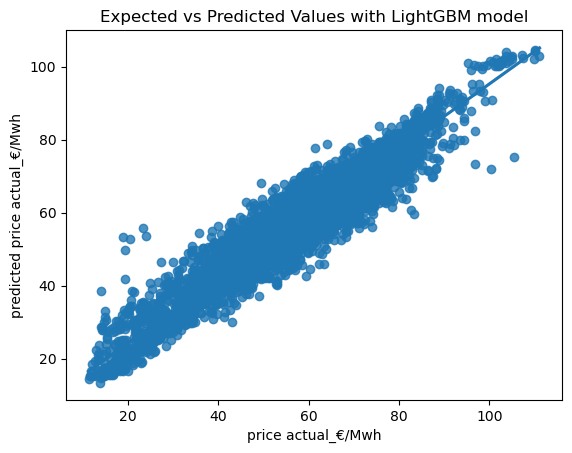

In [983]:

sn.regplot(x = "price actual_€/Mwh", y = "predicted price actual_€/Mwh",data=plotData ,fit_reg=True)

plt.title ('Expected vs Predicted Values with LightGBM model')
plt.show()

In [984]:
price_day_ahead_plot = price_day_ahed_test.reset_index()
price_day_ahead_plot= price_day_ahead_plot.drop('time', axis=1)


In [1045]:


plotData['price day ahead_€/Mwh'] = price_day_ahead_plot

plotData['Expected discrepancy'] = abs(plotData['price day ahead_€/Mwh']-
                                                   plotData['price actual_€/Mwh'])
plotData['Predicted discrepancy'] = abs(plotData['price actual_€/Mwh']-
                                                   plotData['predicted price actual_€/Mwh'])
total_datapoints = plotData.shape[0]

predictions_better_than_TSO = plotData[plotData['Expected discrepancy']>
                                           plotData['Predicted discrepancy']].shape[0] /total_datapoints*100
predictions_worse_than_TSO = plotData[plotData['Expected discrepancy']<
                                           plotData['Predicted discrepancy']].shape[0] /total_datapoints*100

average_better = plotData[plotData['Expected discrepancy']>
                                           plotData['Predicted discrepancy']]

average_better = plotData['Predicted discrepancy'].mean() / plotData['price actual_€/Mwh'].mean()
   
average_better = average_better*100

TSO_average_better = plotData['Expected discrepancy'].mean() / plotData['price actual_€/Mwh'].mean()
   
TSO_average_better = TSO_average_better*100

print(f"Better than TSO: {predictions_better_than_TSO:4.2f} % of the time" )
print(f"Predicted on average % from actual price:  {average_better:4.2f} % " )
print(f"TSO on average % from actual price:  {TSO_average_better:4.2f} % " )

plotData.head(20)

#plt.plot(plotData['Expected discrepancy'],'r+')
#plt.plot(plotData['Predicted discrepancy error'],'bo')




Better than TSO: 93.66 % of the time
Predicted on average % from actual price:  4.45 % 
TSO on average % from actual price:  18.17 % 


,price actual_€/Mwh,predicted price actual_€/Mwh,price day ahead_€/Mwh,Expected discrepancy,Predicted discrepancy
0,42.32,43.654205,36.35,5.97,1.334205
1,69.22,64.702066,55.35,13.87,4.517934
2,57.09,56.909839,51.17,5.92,0.180161
3,56.56,56.142104,45.01,11.55,0.417896
4,73.72,70.234246,59.89,13.83,3.485754
5,69.92,69.996509,65.96,3.96,0.076509
6,44.26,46.336528,39.00,5.26,2.076528
7,58.38,59.977445,54.54,3.84,1.597445
8,51.84,57.607075,65.71,13.87,5.767075
9,68.77,70.885090,59.99,8.78,2.115090


In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

degrees = [1, 2, 3, 4, 5]

for i in range(len(degrees)):

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression)
        ])
    X_train_poly = pipeline.fit(X_train, y_train)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(X_train_poly, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    
    score_mean = scores.mean()
    print(f"  degree={degrees[i]:4d}, score_mean={score_mean:4.2f},  {polynomial_features}") 
    for i in range(len(scores)):
       print(f"      CV fold {i}  =>  score = {scores[i]:.2}")


  degree=   1, score_mean=-70.68,  PolynomialFeatures(degree=1, include_bias=False)
      CV fold 0  =>  score = -6.9e+01
      CV fold 1  =>  score = -7.5e+01
      CV fold 2  =>  score = -7.1e+01
      CV fold 3  =>  score = -6.9e+01
      CV fold 4  =>  score = -6.6e+01
      CV fold 5  =>  score = -7e+01
      CV fold 6  =>  score = -7.7e+01
      CV fold 7  =>  score = -6.9e+01
      CV fold 8  =>  score = -7.4e+01
      CV fold 9  =>  score = -6.8e+01
  degree=   2, score_mean=-39.72,  PolynomialFeatures(include_bias=False)
      CV fold 0  =>  score = -3.8e+01
      CV fold 1  =>  score = -4e+01
      CV fold 2  =>  score = -4e+01
      CV fold 3  =>  score = -3.9e+01
      CV fold 4  =>  score = -3.8e+01
      CV fold 5  =>  score = -3.9e+01
      CV fold 6  =>  score = -4.3e+01
      CV fold 7  =>  score = -3.9e+01
      CV fold 8  =>  score = -4.2e+01
      CV fold 9  =>  score = -3.9e+01
  degree=   3, score_mean=-32.94,  PolynomialFeatures(degree=3, include_bias=False)
    

In [962]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
X_train_scaled = scale.fit_transform(X_train) 
X_test_scaled = scale.fit_transform(X_test)
n_epochs = 7
for epoch in range(n_epochs):
    
    mlp = MLPRegressor(activation = 'tanh',    # aktiveringsfunktion 
                       hidden_layer_sizes = epoch+1, # antal skjulte neuroner
                       alpha = 0.5,           # regulariseringsparameter, her meget lille
                       solver = 'lbfgs',       # quasi-Newton solver
                       max_iter=99999999999999,
                       verbose = True)


    mlp.fit(X_train_scaled, y_train)

    y_train_predict = mlp.predict(X_train_scaled)
    y_test_predict   = mlp.predict(X_test_scaled)

    mse_train=mean_squared_error(y_train, y_train_predict)
    mse_val  =mean_squared_error(y_test  , y_test_predict)

    print(f"  epoch={epoch:4d}, mse_train={mse_train:4.2f}, mse_val={mse_val:4.2f}")


  epoch=   0, mse_train=70.59, mse_val=77.66
  epoch=   1, mse_train=200.15, mse_val=205.75
  epoch=   2, mse_train=70.60, mse_val=77.70
  epoch=   3, mse_train=70.64, mse_val=77.64
  epoch=   4, mse_train=70.62, mse_val=77.63
  epoch=   5, mse_train=49.22, mse_val=56.00
  epoch=   6, mse_train=61.37, mse_val=70.56
